# 1. Setup

Standard imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime

Reading our data

In [2]:
register = pd.read_csv("register.csv")
rooms = pd.read_csv("rooms.csv")

# 2. Feature Engineering

- Summing the amount column for the same room and the same month to get the total energy consumed in a month
- Left Joining register and rooms dataframes

In [3]:
grouped = register.groupby(["legal_entity", "service_category", "room_id", "month"])["amount"].sum().reset_index()
joined = pd.merge(grouped, rooms, on="room_id", how="left")
joined.head()

,legal_entity,service_category,room_id,month,amount,building_id,room_area,build_year,building_floors,building_type,building_func,x_coord,y_coord
0,False,Dvinarė kaina,005f6379f5dc0e1,2018-11-01,0.74,0a425666b45790e,45.1,1968-01-01,5.0,Gyvenamasis (trijų ir daugiau butų - daugiaauk...,Gyvenamasis (trijų ir daugiau butų - daugiaauk...,456564.0,6199541.0
1,False,Dvinarė kaina,005f6379f5dc0e1,2018-12-01,0.74,0a425666b45790e,45.1,1968-01-01,5.0,Gyvenamasis (trijų ir daugiau butų - daugiaauk...,Gyvenamasis (trijų ir daugiau butų - daugiaauk...,456564.0,6199541.0
2,False,Dvinarė kaina,005f6379f5dc0e1,2019-01-01,0.63,0a425666b45790e,45.1,1968-01-01,5.0,Gyvenamasis (trijų ir daugiau butų - daugiaauk...,Gyvenamasis (trijų ir daugiau butų - daugiaauk...,456564.0,6199541.0
3,False,Dvinarė kaina,005f6379f5dc0e1,2019-02-01,0.63,0a425666b45790e,45.1,1968-01-01,5.0,Gyvenamasis (trijų ir daugiau butų - daugiaauk...,Gyvenamasis (trijų ir daugiau butų - daugiaauk...,456564.0,6199541.0
4,False,Dvinarė kaina,005f6379f5dc0e1,2019-03-01,0.63,0a425666b45790e,45.1,1968-01-01,5.0,Gyvenamasis (trijų ir daugiau butų - daugiaauk...,Gyvenamasis (trijų ir daugiau butų - daugiaauk...,456564.0,6199541.0


- Dropping useless columns like room_id, building_id, because they logically don't have an impact on the target column, or we don't want to rely on them for a prediction.
- Converting datetime columns to numerical columns

In [4]:
dropped = joined.drop(["room_id", "building_id", "building_type"], axis=1)

dropped["build_year"] = pd.to_datetime(dropped["build_year"])
dropped["build_year"] = dropped["build_year"].dt.year

dropped["month"] = pd.to_datetime(dropped["month"])
dropped["month"] = dropped["month"].dt.month

dropped.head()

,legal_entity,service_category,month,amount,room_area,build_year,building_floors,building_func,x_coord,y_coord
0,False,Dvinarė kaina,11,0.74,45.1,1968.0,5.0,Gyvenamasis (trijų ir daugiau butų - daugiaauk...,456564.0,6199541.0
1,False,Dvinarė kaina,12,0.74,45.1,1968.0,5.0,Gyvenamasis (trijų ir daugiau butų - daugiaauk...,456564.0,6199541.0
2,False,Dvinarė kaina,1,0.63,45.1,1968.0,5.0,Gyvenamasis (trijų ir daugiau butų - daugiaauk...,456564.0,6199541.0
3,False,Dvinarė kaina,2,0.63,45.1,1968.0,5.0,Gyvenamasis (trijų ir daugiau butų - daugiaauk...,456564.0,6199541.0
4,False,Dvinarė kaina,3,0.63,45.1,1968.0,5.0,Gyvenamasis (trijų ir daugiau butų - daugiaauk...,456564.0,6199541.0


Selecting rows only for a certain category

In [61]:
filtered = dropped[dropped["service_category"] == "Šiluma"]
filtered.drop(['service_category'], axis=1, inplace=True)
len(filtered), len(dropped)
filtered.head()

C:\Users\zygim\AppData\Local\Temp\ipykernel_9496\491170069.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered.drop(['service_category'], axis=1, inplace=True)


,legal_entity,month,amount,room_area,build_year,building_floors,building_func,x_coord,y_coord
6670598,False,11,676.0647,50.1,1987.0,5.0,Gyvenamasis (trijų ir daugiau butų - daugiaauk...,453840.0,6198465.0
6670599,False,12,994.0728,50.1,1987.0,5.0,Gyvenamasis (trijų ir daugiau butų - daugiaauk...,453840.0,6198465.0
6670600,False,1,1189.3836,50.1,1987.0,5.0,Gyvenamasis (trijų ir daugiau butų - daugiaauk...,453840.0,6198465.0
6670601,False,2,926.7941,50.1,1987.0,5.0,Gyvenamasis (trijų ir daugiau butų - daugiaauk...,453840.0,6198465.0
6670602,False,3,887.8715,50.1,1987.0,5.0,Gyvenamasis (trijų ir daugiau butų - daugiaauk...,453840.0,6198465.0


Removing negative energy amounts (doesn't make sense?), also considered removing outliers, but I don't think they are errors and there's very few of them, but it would be bad to remove them as they might represent buildings that have different functions. If you look at the top consumers of energy it's generally hospitals, clinics and administrative buildings, which represent a very small subset of the data.

In [ ]:
filtered = filtered[filtered["amount"] > 0]

Splitting dataset into features and target

In [80]:
X, y = filtered.drop(["amount"], axis=1), filtered["amount"]

Spliting dataset into train and test splits, dataset is very large so we can afford a smaller fraction of the dataset to be allocated to evaluation

In [81]:
from sklearn.model_selection import train_test_split

X_train, X_validtest, y_train, y_validtest = train_test_split(X, y, test_size=0.1, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_validtest, y_validtest, test_size=0.3, random_state=42)
len(X_train), len(X_valid), len(X_test)

(2843838, 221187, 94795)

# 3. Cleaning, Normalization

Using column transformer and various encoders to prepare data for modelling

In [68]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer

num_pipeline = Pipeline([
    ("imp", SimpleImputer()),
    ("scaler", StandardScaler())
])

int_pipeline = Pipeline([
    ("imp", SimpleImputer(strategy="median")),
])

ohe_pipeline = Pipeline([
    ("imp", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(sparse_output=False, handle_unknown="ignore"))
])

ord_pipeline = Pipeline([
    ("ord", OrdinalEncoder()),
    ("imp", SimpleImputer(strategy="most_frequent")),
])

num_cols = ["room_area", "x_coord", "y_coord"]
int_cols = ["build_year", "building_floors", "month"]
ohe_cols = ["building_func"]
ord_cols = ["legal_entity"]

processor = ColumnTransformer([
    ("num", num_pipeline, num_cols),
    ("int", int_pipeline, int_cols),
    ("ohe", ohe_pipeline, ohe_cols),
    ("ord", ord_pipeline, ord_cols)
])

Applying the transformations to our data

In [84]:
X_train_proc = pd.DataFrame(processor.fit_transform(X_train))
X_test_proc = pd.DataFrame(processor.transform(X_test))
X_valid_proc = pd.DataFrame(processor.transform(X_valid))
X_validtest_proc = pd.DataFrame(processor.transform(X_validtest))

feat_names = processor.get_feature_names_out()
X_train_proc.columns = feat_names
X_test_proc.columns = feat_names
X_valid_proc.columns = feat_names
X_validtest_proc.columns = feat_names

Final result looks like this:

In [11]:
X_train_proc.head(3)

,num__room_area,num__x_coord,num__y_coord,int__build_year,int__building_floors,int__month,ohe__building_func_Administracinė,ohe__building_func_Gamybos,ohe__building_func_Gydymo,ohe__building_func_Gyvenamasis (individualus pastatas),...,ohe__building_func_Kultūros,ohe__building_func_Maitinimo,ohe__building_func_Mokslo,ohe__building_func_Prekybos,ohe__building_func_Religinės,ohe__building_func_Sandėliavimo,ohe__building_func_Sporto,ohe__building_func_Transporto,ohe__building_func_Viešbučių,ord__legal_entity
0,-0.016947,0.722492,-2.677047,1972.0,5.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.007234,-3.670173,3.243656,1982.0,5.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.008523,-0.066517,-0.272363,1980.0,5.0,12.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# 4. Modelling

Using XGBoost model, as gradient boosted decision trees usually work best for tabular datasets

Evaluating a dummy regressor to use as a baseline for comparison basically meaning it tries to guess the actual values by predicting the mean value of the target, RMSE = 3697, MAE = 543

In [70]:
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

dummy_regressor = DummyRegressor(strategy='mean')
dummy_regressor.fit(X_train_proc, y_train)

# Predict on the test set
y_pred = dummy_regressor.predict(X_test_proc)

# Evaluate the performance
mse = mean_squared_error(y_validtest, y_pred, squared=False)
mae = mean_absolute_error(y_validtest, y_pred)
print(f"Root Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")

Root Mean Squared Error: 3450.192285244153
Mean Absolute Error: 541.7497590080853


In [71]:
from xgboost import XGBRegressor

xgb_model = XGBRegressor()
xgb_model.fit(X_train_proc, y_train, eval_set=[(X_test_proc, y_validtest)], verbose=True)

[0]	validation_0-rmse:2704.89469
[1]	validation_0-rmse:2247.58547
[2]	validation_0-rmse:1942.80066
[3]	validation_0-rmse:1740.58839
[4]	validation_0-rmse:1626.64110
[5]	validation_0-rmse:1508.33878
[6]	validation_0-rmse:1419.05680
[7]	validation_0-rmse:1374.49886
[8]	validation_0-rmse:1346.32047
[9]	validation_0-rmse:1295.77258
[10]	validation_0-rmse:1260.44236
[11]	validation_0-rmse:1236.86830
[12]	validation_0-rmse:1216.13711
[13]	validation_0-rmse:1208.66019
[14]	validation_0-rmse:1205.71318
[15]	validation_0-rmse:1188.29834
[16]	validation_0-rmse:1166.97803
[17]	validation_0-rmse:1152.72723
[18]	validation_0-rmse:1143.92541
[19]	validation_0-rmse:1129.50294
[20]	validation_0-rmse:1113.86083
[21]	validation_0-rmse:1089.63440
[22]	validation_0-rmse:1082.50975
[23]	validation_0-rmse:1078.19109
[24]	validation_0-rmse:1069.02609
[25]	validation_0-rmse:1063.70180
[26]	validation_0-rmse:1047.33276
[27]	validation_0-rmse:1034.22726
[28]	validation_0-rmse:1019.62498
[29]	validation_0-rmse:1

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [60]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
y_preds = xgb_model.predict(X_test_proc)
print(mean_absolute_error(y_test.reset_index(drop=True), y_preds))

154.37184747709767


So for the model it performs really well on smaller target values, because there are way more samples to train on, and the MAE shows that. It's around 150 for the entire model, on the other hand the RMSE is about 800 which makes sense, because the model performs poorly on edge cases where there are only a few samples and RMSE is more susceptible to outliers, but it's important to leave them as they're not errors, and they don't really affect the performance for the smaller target ranges.

In [72]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

for i in range(1000, 30000, 1000):
    y_test_proc = y_validtest.reset_index(drop=True)
    indices = (y_test_proc < i) & (y_test_proc > i-1000) 
    y_test_proc = y_test_proc[indices]
    X_tests_proc = X_test_proc[indices]
    y_preds = xgb_model.predict(X_tests_proc)
    print(f"MAE of {i-1000} to {i} is {mean_absolute_error(y_test_proc, y_preds)}, sample length: {len(y_test_proc)}")

MAE of 0 to 1000 is 101.42743522026944, sample length: 258200
MAE of 1000 to 2000 is 186.64906161966846, sample length: 52363
MAE of 2000 to 3000 is 936.2009154365757, sample length: 1461
MAE of 3000 to 4000 is 1950.712711349498, sample length: 273
MAE of 4000 to 5000 is 2380.604259982076, sample length: 164
MAE of 5000 to 6000 is 2332.000824472953, sample length: 102
MAE of 6000 to 7000 is 2581.153085634429, sample length: 116
MAE of 7000 to 8000 is 2776.1839408419833, sample length: 89
MAE of 8000 to 9000 is 2587.9904633018095, sample length: 76
MAE of 9000 to 10000 is 3934.928781177172, sample length: 59
MAE of 10000 to 11000 is 3879.8879097964636, sample length: 57
MAE of 11000 to 12000 is 3486.0928298332556, sample length: 67
MAE of 12000 to 13000 is 3779.8986778362773, sample length: 46
MAE of 13000 to 14000 is 3571.2181549273573, sample length: 57
MAE of 14000 to 15000 is 3679.074799986294, sample length: 57
MAE of 15000 to 16000 is 4777.09021274295, sample length: 41
MAE of 160

Most important features plotted

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

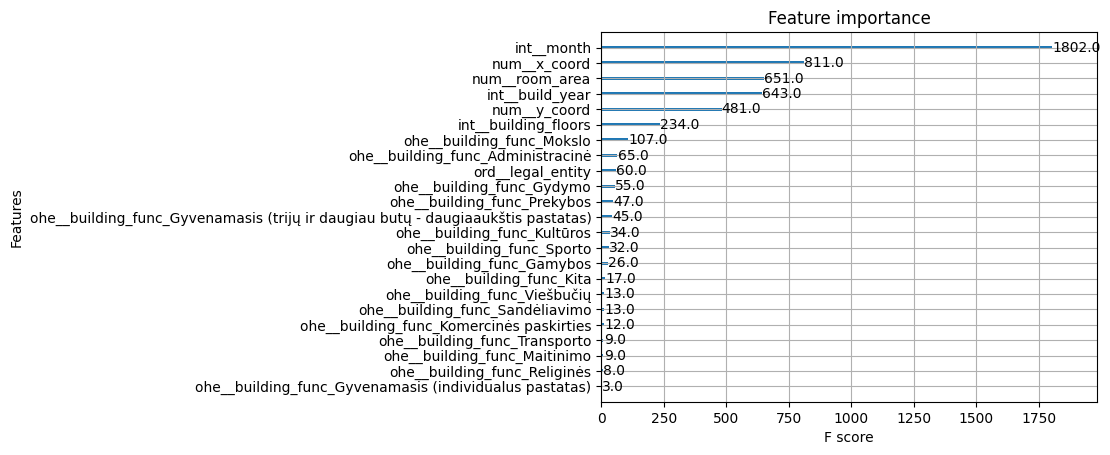

In [63]:
import xgboost as xgb

xgb.plot_importance(xgb_model)

# 5. Hyperparameter optimization using Optuna

In [85]:
dtrain = xgb.DMatrix(data=X_train_proc, label=y_train)
dvalid = xgb.DMatrix(data=X_valid_proc, label=y_valid)
dtest = xgb.DMatrix(data=X_test_proc, label=y_test)
dtrainvalid = xgb.DMatrix(data=X_validtest_proc, label=y_validtest)

In [86]:
metric = 'rmse'
base_params = {
    'objective': 'reg:squarederror',
    'eval_metric': metric,
}

In [87]:
def score_model(model: xgb.core.Booster, dmat: xgb.core.DMatrix) -> float:
    y_true = dmat.get_label() 
    y_pred = model.predict(dmat) 
    return mean_squared_error(y_true, y_pred, squared=False)

In [99]:
import time
learning_rate = 0.8

params = {
    'tree_method': 'approx',
    'learning_rate': learning_rate
}
params.update(base_params)
tic = time.time()
model = xgb.train(params=params, dtrain=dtrain,
                  evals=[(dtrain, 'train'), (dvalid, 'valid')],
                  num_boost_round=10000,
                  early_stopping_rounds=10,
                  verbose_eval=1)
print(f'{time.time() - tic:.1f} seconds')

[0]	train-rmse:1782.55070	valid-rmse:1901.60327
[1]	train-rmse:1477.73376	valid-rmse:1571.69105
[2]	train-rmse:1292.96732	valid-rmse:1353.74336
[3]	train-rmse:1231.48850	valid-rmse:1279.26678
[4]	train-rmse:1174.22039	valid-rmse:1218.57824
[5]	train-rmse:1147.08587	valid-rmse:1180.24397
[6]	train-rmse:1123.46490	valid-rmse:1137.77856
[7]	train-rmse:1120.20547	valid-rmse:1132.69033
[8]	train-rmse:1091.38332	valid-rmse:1101.36461
[9]	train-rmse:1081.44908	valid-rmse:1084.65675
[10]	train-rmse:1077.88133	valid-rmse:1081.00290
[11]	train-rmse:1069.54768	valid-rmse:1073.22128
[12]	train-rmse:1062.71401	valid-rmse:1062.54872
[13]	train-rmse:1049.56034	valid-rmse:1062.94141
[14]	train-rmse:1035.33707	valid-rmse:1044.25615
[15]	train-rmse:1017.01597	valid-rmse:1040.28916
[16]	train-rmse:973.12507	valid-rmse:998.63158
[17]	train-rmse:968.51034	valid-rmse:994.95510
[18]	train-rmse:964.39913	valid-rmse:991.81985
[19]	train-rmse:943.43115	valid-rmse:962.69126
[20]	train-rmse:939.54706	valid-rmse:9

In [100]:
def objective(trial):
    params = {
        'tree_method': trial.suggest_categorical('tree_method', ['approx', 'hist']),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 250),
        'subsample': trial.suggest_float('subsample', 0.1, 1.0),
        'colsample_bynode': trial.suggest_float('colsample_bynode', 0.1, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.001, 25, log=True),
        'learning_rate': learning_rate,
    }
    num_boost_round = 10000
    params.update(base_params)
    pruning_callback = optuna.integration.XGBoostPruningCallback(trial, f'valid-{metric}')
    model = xgb.train(params=params, dtrain=dtrain, num_boost_round=num_boost_round,
                      evals=[(dtrain, 'train'), (dvalid, 'valid')],
                      early_stopping_rounds=50,
                      verbose_eval=0,
                      callbacks=[pruning_callback])
    trial.set_user_attr('best_iteration', model.best_iteration)
    return model.best_score

In [112]:
sampler = optuna.samplers.TPESampler(seed=42)
study = optuna.create_study(direction='minimize', sampler=sampler)
tic = time.time()
while time.time() - tic < 3600:
    study.optimize(objective, n_trials=1)

[I 2025-02-13 17:05:16,904] A new study created in memory with name: no-name-d7535cdb-76d1-475f-aa5b-75a1cc1d3d38
[I 2025-02-13 17:09:16,122] Trial 0 finished with value: 1060.3920799678565 and parameters: {'tree_method': 'hist', 'max_depth': 10, 'min_child_weight': 150, 'subsample': 0.24041677639819287, 'colsample_bynode': 0.2403950683025824, 'reg_lambda': 0.001800728515054226}. Best is trial 0 with value: 1060.3920799678565.
[I 2025-02-13 17:10:17,609] Trial 1 finished with value: 816.7974683006909 and parameters: {'tree_method': 'approx', 'max_depth': 10, 'min_child_weight': 6, 'subsample': 0.9729188669457949, 'colsample_bynode': 0.8491983767203796, 'reg_lambda': 0.008587261143813469}. Best is trial 1 with value: 816.7974683006909.
[I 2025-02-13 17:13:18,916] Trial 2 finished with value: 975.0210742012845 and parameters: {'tree_method': 'hist', 'max_depth': 6, 'min_child_weight': 132, 'subsample': 0.48875051677790415, 'colsample_bynode': 0.36210622617823773, 'reg_lambda': 0.49078618

In [113]:
print('Stage 1 ==============================')
print(f'best score = {study.best_trial.value}')
print('boosting params ---------------------------')
print(f'fixed learning rate: {learning_rate}')
print(f'best boosting round: {study.best_trial.user_attrs["best_iteration"]}')
print('best tree params --------------------------')
for k, v in study.best_trial.params.items():
    print(k, ':', v)

Stage 1 ==============================
best score = 799.3831549991581
boosting params ---------------------------
fixed learning rate: 0.8
best boosting round: 444
best tree params --------------------------
tree_method : approx
max_depth : 11
min_child_weight : 237
subsample : 0.9961532940366143
colsample_bynode : 0.7251026525550607
reg_lambda : 0.02160668486141079


In [114]:
print(study.best_trial.params)

{'tree_method': 'approx', 'max_depth': 11, 'min_child_weight': 237, 'subsample': 0.9961532940366143, 'colsample_bynode': 0.7251026525550607, 'reg_lambda': 0.02160668486141079}


{'tree_method': 'approx', 'max_depth': 11, 'min_child_weight': 237, 'subsample': 0.9961532940366143, 'colsample_bynode': 0.7251026525550607, 'reg_lambda': 0.02160668486141079}

In [116]:
low_learning_rate = 0.01

params = {}
params.update(base_params)
params.update(study.best_trial.params)
params['learning_rate'] = low_learning_rate
model_stage2 = xgb.train(params=params, dtrain=dtrain, 
                         num_boost_round=10000,
                         evals=[(dtrain, 'train'), (dvalid, 'valid')],
                         early_stopping_rounds=50,
                         verbose_eval=1)

[0]	train-rmse:3480.35954	valid-rmse:3472.21482
[1]	train-rmse:3461.32562	valid-rmse:3452.68853
[2]	train-rmse:3442.58322	valid-rmse:3433.77527
[3]	train-rmse:3424.15510	valid-rmse:3414.62376
[4]	train-rmse:3405.07725	valid-rmse:3395.43398
[5]	train-rmse:3385.52862	valid-rmse:3376.15672
[6]	train-rmse:3365.98346	valid-rmse:3357.00140
[7]	train-rmse:3348.04296	valid-rmse:3338.79312
[8]	train-rmse:3330.48577	valid-rmse:3320.53127
[9]	train-rmse:3312.58020	valid-rmse:3302.54744
[10]	train-rmse:3295.41165	valid-rmse:3284.91632
[11]	train-rmse:3278.83256	valid-rmse:3268.04451
[12]	train-rmse:3262.56504	valid-rmse:3251.55231
[13]	train-rmse:3246.13177	valid-rmse:3235.12637
[14]	train-rmse:3230.07599	valid-rmse:3218.70091
[15]	train-rmse:3214.56070	valid-rmse:3202.65778
[16]	train-rmse:3199.57707	valid-rmse:3187.30320
[17]	train-rmse:3183.86072	valid-rmse:3171.06003
[18]	train-rmse:3167.56320	valid-rmse:3154.66022
[19]	train-rmse:3152.48192	valid-rmse:3139.22245
[20]	train-rmse:3137.21928	val

KeyboardInterrupt: 